In [8]:
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def load_xin_file(filename):
    data = np.zeros(shape=(104,200))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line[:-1]
            line = line.split(" ")
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
    data = data.transpose()
    data = data[0]
    return data

def load_yin_file(filename):
    data = np.zeros(shape=(200,104))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line.replace("{","")
            line = line.replace("}","")
            line = line[:-2]
            line = line.split(",")
            if len(line) == 1:
                continue
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
    return data

def load_actual_file(filename):
    data = np.zeros(shape=(104,200))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line[:-1]
            line = line.split(" ")
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
            
    data = data.transpose()
    return data

In [34]:
ls_overlay = Overlay('./ls_ip/ls_ip.bit')
ls_dma = ls_overlay.axi_dma_0
ls_leastsq = ls_overlay.leastSquare_0

In [35]:
in_buffer = allocate(shape=(2*104,), dtype=np.float32)
out_buffer = allocate(shape=(104,), dtype=np.float32)

In [36]:
def run_ls_ip(yin, xin):
    for idx in range(2*104):
        if idx<104:
            in_buffer[idx] = yin[idx]
        else:
            in_buffer[idx] = xin[idx-104]
    
    ls_leastsq.write(0x00, 0x1)
    ls_dma.sendchannel.transfer(in_buffer)
    ls_dma.recvchannel.transfer(out_buffer)
    return out_buffer

In [37]:
N_SNR = 7
N_CH = 200

ls_IP_output = np.zeros([N_SNR, N_CH, 104])
ls_Err_DNN_hw = np.zeros([N_SNR,])
ls_Phf_hw = np.zeros([N_SNR,])

for n_snr in range(N_SNR):
    print(f"\nSignal: {n_snr+1}")
    
    xin = load_xin_file("./data/XinC_1.txt")
    yin = load_yin_file(f"./data/Yinc_m{n_snr+1}m.dat")
    act = load_actual_file(f"./data/actual{n_snr+1}.txt")
    
    for n_ch in range(N_CH):
        print(f"  Channel: {n_ch+1}\r", end="")
        op = run_ls_ip(yin[n_ch], xin)        
        ls_IP_output[n_snr,n_ch,:] = op
    
    # 2-norm (largest sing. value)
    ls_Err_DNN_hw[n_snr] += np.linalg.norm(act - ls_IP_output[n_snr], 2)**2
    ls_Phf_hw[n_snr] +=  np.linalg.norm(act, 2)**2

ls_Err_DNN_hw /=  200
ls_Phf_hw /= 200
ls_Err_DNN_normalized_hw = ls_Err_DNN_hw / ls_Phf_hw


Signal: 1
  Channel: 200
Signal: 2
  Channel: 200
Signal: 3
  Channel: 200
Signal: 4
  Channel: 200
Signal: 5
  Channel: 200
Signal: 6
  Channel: 200
Signal: 7


In [38]:
dnn_overlay = Overlay('./opt_ip.bit')
dnn_dma = dnn_overlay.axi_dma_0
dnn_leastsq = dnn_overlay.leastSquare_0
dnn_neuralnet = dnn_overlay.neuralNetworkHw_0

In [39]:
from pynq import allocate

in_buffer = allocate(shape=(2*104,), dtype=np.float32)
out_buffer = allocate(shape=(104,), dtype=np.float32)

In [40]:
def run_dnn_ip(yin, xin):
    for idx in range(2*104):
        if idx<104:
            in_buffer[idx] = yin[idx]
        else:
            in_buffer[idx] = xin[idx-104]
    
    dnn_leastsq.write(0x00, 0x1)
    dnn_neuralnet.write(0x00, 0x1)
    dnn_dma.sendchannel.transfer(in_buffer)
    dnn_dma.recvchannel.transfer(out_buffer)

    return out_buffer

In [41]:
N_SNR = 7
N_CH = 200

dnn_IP_output = np.zeros([N_SNR, N_CH, 104])
dnn_Err_DNN_hw = np.zeros([N_SNR,])
dnn_Phf_hw = np.zeros([N_SNR,])

for n_snr in range(N_SNR):
    print(f"\nSignal: {n_snr+1}")
    
    xin = load_xin_file("./data/XinC_1.txt")
    yin = load_yin_file(f"./data/Yinc_m{n_snr+1}m.dat")
    act = load_actual_file(f"./data/actual{n_snr+1}.txt")
    
    for n_ch in range(N_CH):
        print(f"  Channel: {n_ch+1}\r", end="")
        op = run_dnn_ip(yin[n_ch], xin)        
        op = op[:104]
        dnn_IP_output[n_snr,n_ch,:] = op
    
    # 2-norm (largest sing. value)
    dnn_Err_DNN_hw[n_snr] += np.linalg.norm(act - dnn_IP_output[n_snr], 2)**2
    dnn_Phf_hw[n_snr] +=  np.linalg.norm(act, 2)**2

dnn_Err_DNN_hw /=  200
dnn_Phf_hw /= 200
dnn_Err_DNN_normalized_hw = dnn_Err_DNN_hw / dnn_Phf_hw


Signal: 1
  Channel: 200
Signal: 2
  Channel: 200
Signal: 3
  Channel: 200
Signal: 4
  Channel: 200
Signal: 5
  Channel: 200
Signal: 6
  Channel: 200
Signal: 7


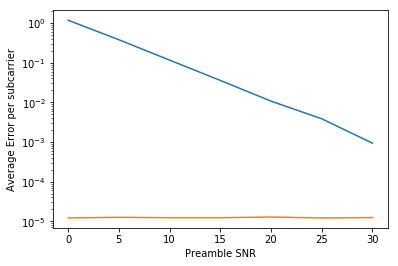

In [42]:
plt.semilogy(np.arange(0, N_SNR*5, 5), ls_Err_DNN_normalized_hw)
plt.semilogy(np.arange(0, N_SNR*5, 5), dnn_Err_DNN_normalized_hw)
plt.xlabel("Preamble SNR")
plt.ylabel("Average Error per subcarrier")
plt.show()